# Logistic Regression for M&A Data

(14997, 32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Misclassification rate on training data = 16.09 %
Misclassification rate on testing data = 15.869521713027817 %


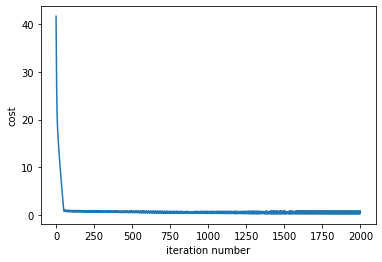

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # package for plotting
np.random.seed(1)
'''
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Import M&A training and testing data
file_id = '1L7sbJIMkjAoXuIZTFrbeWCuu_LV5ff0n'
downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
ma_data = downloaded.GetContentString

print(ma_data)
'''
m_a_data = pd.read_csv('clean_m&a.csv')
m_a_data['announced'] = pd.to_datetime(m_a_data['announced']).astype(int) / 10**9
m_a_data['announced'] = m_a_data['announced'] / m_a_data['announced'][0]
#print(m_a_data.dtypes)
#print(m_a_data.head())
m_a_data['outcomes'] = m_a_data.outcome
m_a_data.drop('outcome',inplace=True,axis=1) #moves outcome to the last column for convenience
m_a_data.drop('Unnamed: 0',inplace=True,axis=1)
print(m_a_data.shape)

# Select the first m inputs and labels
n = len(m_a_data)
m=10000

# Shuffle the whole dataset
m_a_data = m_a_data.sample(frac=1)
#print(m_a_data.head())


# Define the training data
Xtrain= m_a_data.iloc[:m,:-1]
Ytrain= m_a_data.iloc[:m,-1]

X=Xtrain.iloc[:m,:].to_numpy()
Y=Ytrain.iloc[:m].to_numpy()

# Define the testing data
Xtest=m_a_data.iloc[m:,:-1].to_numpy()
Ytest=m_a_data.iloc[m:,-1].to_numpy()


# A numerically stable implementation of the logistic sigmoid
def sigmoid(z):
    return np.where(z>0,1/(1+np.exp(-z)),np.exp(z)/(1+np.exp(z)))

# Function to compute the model output, yhat
def yhat(x,w,b):
  return sigmoid(w@x.T+b)

# # Function to compute the loss
# # It is numerically unstable, so use the one below instead.
# def Loss(x,y,w,b):
#   return -y*np.log(yhat(x,w,b))-(1-y)*np.log(1-yhat(x,w,b))

# A numerically stable loss function
# This is mathematically equivalent to the one above, 
# but numerically more stable
import scipy.special
def Loss(X,Y,w,b):
  Z=w@X.T+b
  L=np.zeros_like(Y)
  L[Y==0]=scipy.special.logsumexp([np.zeros_like(Z[Y==0]), Z[Y==0]],axis=0)
  L[Y==1]=scipy.special.logsumexp([np.zeros_like(Z[Y==1]), -Z[Y==1]],axis=0)
  return L

# Fucntion to comptue cost, J, of an entire data set
def Cost(X,Y,w,b):
  return (1/np.size(X))*np.sum(Loss(X,Y,w,b))


w=np.random.randn(31) #set the initial weights to random numbers of size 31
b=1

# Number of iterations to do grad descent
niterations=int(2e3)


# Learning rate
epsilon=.00015

losses=np.zeros(niterations+1)
losses[0]=Cost(X,Y,w,b)
for i in range(niterations):
  dJdw=(1/m)*(X.T@(yhat(X,w,b)-Y))
  dJdb=(1/m)*np.sum((yhat(X,w,b)-Y))
  w=w-epsilon*dJdw
  b=b-epsilon*dJdb
  losses[i+1]=Cost(X,Y,w,b)

plt.figure()
plt.plot(losses)
plt.ylabel("cost")
plt.xlabel("iteration number")
#plt.yscale("log")

def Classifier(x,w,b):
  return (yhat(x,w,b)>0.5).astype(float)

# Apply the classifier to the training data, X
Guesses=Classifier(X,w,b)


# Compute misclassification rate
MisClassRate=np.sum(np.abs(Guesses-Y))/m
print("Misclassification rate on training data =",100*MisClassRate,"%")

# Make some testing data compute misclass. rate
TestingGuesses=Classifier(Xtest,w,b)
MisClassRateTesting=np.sum(np.abs(TestingGuesses-Ytest))/(n-m)
print("Misclassification rate on testing data =",100*MisClassRateTesting,"%")

In [3]:
#for confusion matrix -- Use testing data instead.

withdrawn = Ytest[Ytest==0]
completed = Ytest[Ytest==1]
guess_withdrawn = TestingGuesses[Ytest==0]
guess_completed = TestingGuesses[Ytest==1]
print('Actual:W, Predict: C',np.sum(np.abs(withdrawn-guess_withdrawn)))
print('Actual:C, Predict: W',np.sum(np.abs(completed-guess_completed)))
print('Actual:W, Predict: W',len(withdrawn) - np.sum(np.abs(withdrawn-guess_withdrawn)))
print('Actual:C, Predict: C',len(completed) - np.sum(np.abs(completed-guess_completed)))

Actual:W, Predict: C 604.0
Actual:C, Predict: W 189.0
Actual:W, Predict: W 39.0
Actual:C, Predict: C 4165.0


# Deep Neural Net

In [172]:
# MNIST with Keras
# Make sure to set runtime to GPU!

# Import packages
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.utils import np_utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SpatialDropout1D, Dropout

np.random.seed(4)
x_train = Xtrain.to_numpy().reshape(-1,1,31)
y_train = Ytrain.to_numpy().reshape(-1,1)
x_test = Xtest.reshape(-1,1,31)
y_test = Ytest.reshape(-1,1)


print('x_train :', np.shape(x_train))
print('y_train :', np.shape(y_train))
print('x_test :', np.shape(x_test))
print('y_test :', np.shape(y_test))


model = Sequential(name='MA_CNN')

model.add(keras.Input(shape=(1,31)))
model.add(Dense(units=30, activation='relu',kernel_regularizer=l2(.055)))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(.055))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=30, activation='relu',kernel_regularizer=l2(.055)))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

x_train : (10000, 1, 31)
y_train : (10000, 1)
x_test : (4997, 1, 31)
y_test : (4997, 1)
Model: "MA_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 1, 30)             960       
_________________________________________________________________
dense_198 (Dense)            (None, 1, 50)             1550      
_________________________________________________________________
dense_199 (Dense)            (None, 1, 50)             2550      
_________________________________________________________________
dense_200 (Dense)            (None, 1, 50)             2550      
_________________________________________________________________
dense_201 (Dense)            (None, 1, 50)             2550      
_________________________________________________________________
dense_202 (Dense)            (None, 1, 50)             2550      
______________________________________

In [173]:

hist = model.fit(x_train, y_train,
                 epochs=700,
                 batch_size=256,
                 validation_data=(x_test, y_test))

Epoch 1/700
40/40 [==============================] - 2s 15ms/step - loss: 4.0711 - accuracy: 0.8600 - val_loss: 3.1549 - val_accuracy: 0.8713
Epoch 2/700
40/40 [==============================] - 0s 8ms/step - loss: 2.8931 - accuracy: 0.8672 - val_loss: 2.3834 - val_accuracy: 0.8713
Epoch 3/700
40/40 [==============================] - 0s 7ms/step - loss: 2.1670 - accuracy: 0.8690 - val_loss: 1.7500 - val_accuracy: 0.8683
Epoch 4/700
40/40 [==============================] - 0s 7ms/step - loss: 1.6717 - accuracy: 0.8723 - val_loss: 1.3782 - val_accuracy: 0.8679
Epoch 5/700
40/40 [==============================] - 0s 8ms/step - loss: 1.3347 - accuracy: 0.8667 - val_loss: 1.1860 - val_accuracy: 0.8713
Epoch 6/700
40/40 [==============================] - 0s 7ms/step - loss: 1.1301 - accuracy: 0.8673 - val_loss: 0.9903 - val_accuracy: 0.8629
Epoch 7/700
40/40 [==============================] - 0s 7ms/step - loss: 0.9717 - accuracy: 0.8634 - val_loss: 0.8626 - val_accuracy: 0.8703
Epoch 8/700


1/1 [==============================] - 0s 185ms/step - loss: 0.5375 - accuracy: 0.8419
Final Test set Loss: 0.5374835133552551
Final Test set Accuracy: 0.8419051170349121


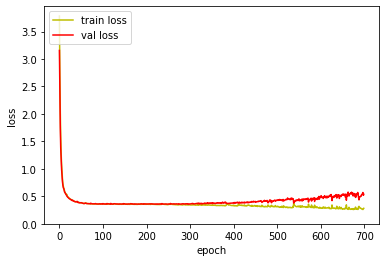

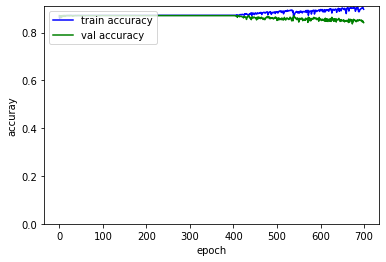

In [174]:
### 4
# Plot the loss and accuracy for training and validation sets

plt.figure()
plt.plot(hist.history['loss'], 'y', label='train loss')
plt.plot(hist.history['val_loss'], 'r', label='val loss')
plt.ylim(bottom=0)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')

plt.figure()
plt.plot(hist.history['accuracy'], 'b', label='train accuracy')
plt.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
plt.ylim(bottom=0)
plt.xlabel('epoch')
plt.ylabel('accuray')
plt.legend(loc='upper left')

# Compute and print final test loss and accuracy
# model.evaluate evaluates the error of your model on 
# the inputs and labels you pass it. 
loss_and_acc = model.evaluate(x_test, y_test, batch_size=np.shape(x_test)[0])
print('Final Test set Loss:',loss_and_acc[0])
print('Final Test set Accuracy:',loss_and_acc[1])

In [175]:
TestingGuesses = np.zeros(len(y_test))
for i in range(len(TestingGuesses)):
  TestingGuesses[i] = model.predict(x_test[i,:,:].reshape(1,1,31))

In [176]:
withdrawn = y_test[y_test==0]
completed = y_test[y_test==1]
guess_withdrawn = TestingGuesses[(y_test==0).reshape(len(y_test))]
guess_completed = TestingGuesses[(y_test==1).reshape(len(y_test))]

print(guess_withdrawn.mean())
print(guess_completed.mean())


guess_completed[guess_completed > .5] = 1
guess_completed[guess_completed < .5] = 0
guess_withdrawn[guess_withdrawn > .5] = 1
guess_withdrawn[guess_withdrawn < .5] = 0

0.802090496135134
0.8762683586038615


In [177]:
print('Actual:W, Predict: C',np.sum(np.abs(withdrawn-guess_withdrawn)))
print('Actual:C, Predict: W',np.sum(np.abs(completed-guess_completed)))
print('Actual:W, Predict: W',len(withdrawn) - np.sum(np.abs(withdrawn-guess_withdrawn)))
print('Actual:C, Predict: C',len(completed) - np.sum(np.abs(completed-guess_completed)))

Actual:W, Predict: C 586.0
Actual:C, Predict: W 204.0
Actual:W, Predict: W 57.0
Actual:C, Predict: C 4150.0


In [179]:
guess_withdrawn = TestingGuesses[(y_test==0).reshape(len(y_test))]
guess_completed = TestingGuesses[(y_test==1).reshape(len(y_test))]

print(min(guess_withdrawn))
print(min(guess_completed))
print(max(guess_withdrawn))
print(max(guess_completed))

0.003514927113428712
0.0006710718735121191
1.0
1.0


In [195]:
print(len(TestingGuesses[(y_test==1).reshape(len(y_test))]))
print(sum(TestingGuesses[(y_test==1).reshape(len(y_test))] > .99))

print(len(TestingGuesses[(y_test==0).reshape(len(y_test))]))
print(sum(TestingGuesses[(y_test==0).reshape(len(y_test))] > .99))

4354
1152
643
86


In [198]:
print(len(TestingGuesses[(y_test==1).reshape(len(y_test))]))
print(sum(TestingGuesses[(y_test==1).reshape(len(y_test))] < .10))

print(len(TestingGuesses[(y_test==0).reshape(len(y_test))]))
print(sum(TestingGuesses[(y_test==0).reshape(len(y_test))] < .10))

4354
60
643
21
